# Ejercicio Covid-19

In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gráficos a nivel mundial

## Preparación general de datos

In [48]:
# Datos https://github.com/CSSEGISandData/COVID-19.git
data = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" )
data.sample(3)

#Saco un dataset con solo los países
data_countries = data.groupby("Country/Region", as_index=False).sum()
#Se ve que están todos y comprobado que suma
data_countries[::]

# Hago transposición de los datos para mover las columnas en filas 
data_trans = data_countries.set_index('Country/Region').transpose()
# Y me quedo sólo con los datos temporales y número de casos
data_time = data_trans[2:]
data_time.tail()

# Cogemos solo determinados países
data_time = data_time[['China', 'France', 'Germany', 'Iran','Italy', 'Korea, South', 'Norway','Spain', 'US', 'United Kingdom']]

#Hago listado de Countries
list_countries = data_time.columns
list_countries

# Para coger los países que en día 20 tienen más de 1000 casos: data_countries = data_countries[data_countries["3/17/20"] >= 1000 ]
data_time.tail(2)

#Convierto la columna fecha en datetime
from datetime import date
data_time.index = pd.to_datetime(data_time.index)
data_time.tail()



Country/Region,China,France,Germany,Iran,Italy,"Korea, South",Norway,Spain,US,United Kingdom
2020-03-26,81782.0,29551.0,43938.0,29406.0,80589.0,9241.0,3369.0,57786.0,83836.0,11812.0
2020-03-27,81897.0,33402.0,50871.0,32332.0,86498.0,9332.0,3755.0,65719.0,101657.0,14745.0
2020-03-28,81999.0,38105.0,57695.0,35408.0,92472.0,9478.0,4015.0,73235.0,121478.0,17312.0
2020-03-29,82122.0,40708.0,62095.0,38309.0,97689.0,9583.0,4284.0,80110.0,140886.0,19780.0
2020-03-30,82198.0,45170.0,66885.0,41495.0,101739.0,9661.0,4445.0,87956.0,161807.0,22453.0


## CSV : covid19_data_drive_actual.csv

In [49]:
######### Confirmados

data_confirmed = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" )
#Saco un dataset con solo los países
data_confirmed = data_confirmed.groupby("Country/Region", as_index=False).sum()
# Hago transposición de los datos para mover las columnas en filas 
data_confirmed = data_confirmed.set_index('Country/Region').transpose()
# Y me quedo sólo con los datos temporales y número de casos
data_confirmed = data_confirmed[2:]
# Cogemos solo determinados países
data_confirmed = data_confirmed[['China', 'France', 'Germany', 'Italy','Spain', 'US', 'United Kingdom']]
data_confirmed = data_confirmed[-1:]
print(data_confirmed)

######### Muertos

data_deaths = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
#Saco un dataset con solo los países
data_deaths = data_deaths.groupby("Country/Region", as_index=False).sum()
#Se ve que están todos y comprobado que suma
data_deaths[::]
# Hago transposición de los datos para mover las columnas en filas 
data_deaths = data_deaths.set_index('Country/Region').transpose()

# Y me quedo sólo con los datos temporales y número de casos
data_deaths = data_deaths[2:]
data_deaths.tail()
# Cogemos solo determinados países
data_deaths = data_deaths[['China', 'France', 'Germany', 'Italy','Spain', 'US', 'United Kingdom']]
data_deaths = data_deaths[-1:]
print(data_deaths)

######### Recuperados

data_recovered = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv" )
#Saco un dataset con solo los países
data_recovered = data_recovered.groupby("Country/Region", as_index=False).sum()
# Hago transposición de los datos para mover las columnas en filas 
data_recovered = data_recovered.set_index('Country/Region').transpose()
# Y me quedo sólo con los datos temporales y número de casos
data_recovered = data_recovered[2:]
# Cogemos solo determinados países
data_recovered = data_recovered[['China', 'France', 'Germany', 'Italy','Spain', 'US', 'United Kingdom']]
data_recovered = data_recovered[-1:]
print(data_recovered)

######### Merge de datos

# Saco la fecha:
from datetime import datetime, timedelta
date_today_intern = date.today()
date_today_intern = date_today_intern.today() - timedelta(days=1) #Quito uno porque esta base de datos siempre muestra datos del día anterior
date_today_intern = date_today_intern.strftime('%d/%m')
print(date_today_intern)

#Juntar ahora datos
data_columns = ['Confirmados' + ' - ' + date_today_intern, 'Curados' + ' - ' + date_today_intern, 'Muertos'+ ' - ' + date_today_intern]

data_together = pd.merge(data_confirmed, data_recovered, how='outer')
data_together = pd.merge(data_together, data_deaths, how='outer')
data_together.index = data_columns
data_together = data_together.transpose()
# data_together = data_together.reindex(columns =data_columns) 
# data_together = data_together.reindex(data_index)

# Exporto CSV
data_together.to_csv('covid19_data_drive_actual.csv', sep = ';')
data_together

Country/Region    China   France  Germany     Italy    Spain        US  \
3/30/20         82198.0  45170.0  66885.0  101739.0  87956.0  161807.0   

Country/Region  United Kingdom  
3/30/20                22453.0  
Country/Region   China  France  Germany    Italy   Spain      US  \
3/30/20         3308.0  3030.0    645.0  11591.0  7716.0  2978.0   

Country/Region  United Kingdom  
3/30/20                 1411.0  
Country/Region    China  France  Germany    Italy    Spain      US  \
3/30/20         75923.0  7964.0  13500.0  14620.0  16780.0  5644.0   

Country/Region  United Kingdom  
3/30/20                  171.0  
30/03


,Confirmados - 30/03,Curados - 30/03,Muertos - 30/03
Country/Region,,,
China,82198.0,75923.0,3308.0
France,45170.0,7964.0,3030.0
Germany,66885.0,13500.0,645.0
Italy,101739.0,14620.0,11591.0
Spain,87956.0,16780.0,7716.0
US,161807.0,5644.0,2978.0
United Kingdom,22453.0,171.0,1411.0


## Gráfico + CSV : covid19_data_drive_from100.csv

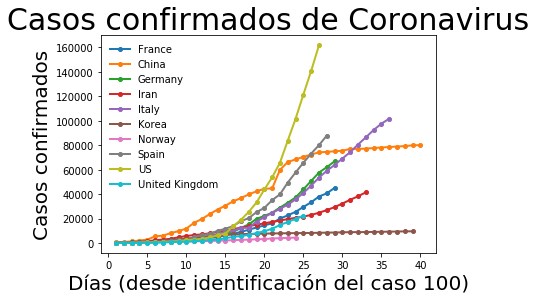

,France,China,Germany,Iran,Italy,"Korea, South",Norway,Spain,US,United Kingdom
36,NaN,78600.0,NaN,NaN,101739.0,9332.0,NaN,NaN,NaN,NaN
37,NaN,78928.0,NaN,NaN,NaN,9478.0,NaN,NaN,NaN,NaN
38,NaN,79356.0,NaN,NaN,NaN,9583.0,NaN,NaN,NaN,NaN
39,NaN,79932.0,NaN,NaN,NaN,9661.0,NaN,NaN,NaN,NaN
40,NaN,80136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
'''Vamos a hacer un gráfico para ver los casos confirmados (desde caso 100)'''

# Rellenar los valores menores de 100 por null
# PROBAR: https://stackoverflow.com/questions/46168450/replace-a-specific-range-of-values-in-a-pandas-dataframe
# data_drive_from100cases = data_time.mask(data_time < 100, 'null')
# data_drive_from100cases.head(2)

# Rellenar los valores menores de 100 por null
# PROBAR: https://stackoverflow.com/questions/46168450/replace-a-specific-range-of-values-in-a-pandas-dataframe
# data_drive_from100cases = data_time.mask(data_time < 100, 'null')
# data_drive_from100cases.head(2)

# Coger solo datos del último mes
data_time_30days = data_time[-200:]
# Si quiero quitar China: data_time_filter = data_time_filter.drop('China', axis=1)
data_time_30days.tail(2)

#Exporto los datos en diferentes arhcivos con casa país
for country in list_countries:
    dataX = data_time_30days[country]
    dataX = dataX[dataX > 100]
    dataX.to_csv('data_' + country + ".csv", index=False, header= country)

#Lista dataframes
dataframes_list = ['dataframe_France', 'dataframe_China', 'dataframe_Germany', 'dataframe_Iran', 'dataframe_Italy', 'dataframe_Korea', 'dataframe_Norway', 'dataframe_Spain', 'dataframe_US', 'dataframe_UnitedKingdom']
dataframes_list[1]

# Creamos los CSV
dataframe_France = pd.read_csv('data_France.csv')
dataframe_China = pd.read_csv('data_China.csv')
dataframe_Germany = pd.read_csv('data_Germany.csv')
dataframe_Iran = pd.read_csv('data_Iran.csv')
dataframe_Italy = pd.read_csv('data_Italy.csv')
dataframe_Korea = pd.read_csv('data_Korea, South.csv')
dataframe_Norway = pd.read_csv('data_Norway.csv')
dataframe_Spain = pd.read_csv('data_Spain.csv')
dataframe_US = pd.read_csv('data_US.csv')
dataframe_UnitedKingdom = pd.read_csv('data_United Kingdom.csv')

#Les añadimos NaN al final y reindexamos
new_index = np.arange(1,41)
dataframe_France = dataframe_France.reindex(new_index)
dataframe_China = dataframe_China.reindex(new_index)
dataframe_Germany = dataframe_Germany.reindex(new_index)
dataframe_Iran = dataframe_Iran.reindex(new_index)
dataframe_Italy = dataframe_Italy.reindex(new_index)
dataframe_Korea = dataframe_Korea.reindex(new_index)
dataframe_Norway = dataframe_Norway.reindex(new_index)
dataframe_Spain = dataframe_Spain.reindex(new_index)
dataframe_US = dataframe_US.reindex(new_index)
dataframe_UnitedKingdom = dataframe_UnitedKingdom.reindex(new_index)

# Lo ploteo
plt.plot(dataframe_France, label='France', marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_China, label='China',marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Germany, label='Germany' ,marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Iran, label='Iran',marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Italy, label='Italy',marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Korea, label='Korea' ,marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Norway, label='Norway' ,marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Spain, label='Spain' ,marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_US, label='US' ,marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_UnitedKingdom, label='United Kingdom',marker='o', markersize=4, linewidth=2)

plt.legend(loc='upper left', frameon=False, fancybox=True)
plt.title('Casos confirmados de Coronavirus', {'fontsize': 30})

plt.xlabel("Días (desde identificación del caso 100)", {'fontsize': 20})
plt.ylabel("Casos confirmados", {'fontsize': 20})
plt.show()

#Juntar dataframes y Exportar CSV completo
data_drive_from100cases = dataframe_France.join([dataframe_China, dataframe_Germany, dataframe_Iran, dataframe_Italy, dataframe_Korea, dataframe_Norway, dataframe_Spain, dataframe_US,dataframe_UnitedKingdom])
data_drive_from100cases.to_csv('covid19_data_drive_from100.csv', sep = ';')
data_drive_from100cases.tail()

## Gráfico + CSV covid19_data_drive_days.csv

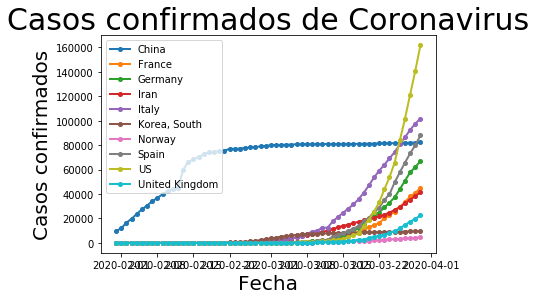

Country/Region,China,France,Germany,Iran,Italy,"Korea, South",Norway,Spain,US,United Kingdom
2020-03-26,81782.0,29551.0,43938.0,29406.0,80589.0,9241.0,3369.0,57786.0,83836.0,11812.0
2020-03-27,81897.0,33402.0,50871.0,32332.0,86498.0,9332.0,3755.0,65719.0,101657.0,14745.0
2020-03-28,81999.0,38105.0,57695.0,35408.0,92472.0,9478.0,4015.0,73235.0,121478.0,17312.0
2020-03-29,82122.0,40708.0,62095.0,38309.0,97689.0,9583.0,4284.0,80110.0,140886.0,19780.0
2020-03-30,82198.0,45170.0,66885.0,41495.0,101739.0,9661.0,4445.0,87956.0,161807.0,22453.0


In [51]:
# Coger solo datos de últimos 60 días
data_time_Xdays = data_time[-60:]
# Si quiero quitar China: data_time_filter = data_time_filter.drop('China', axis=1)
data_time_Xdays.tail(2)

'''Vamos a hacer un gráfico para ver los casos confirmados por fechas'''
plt.plot(data_time_Xdays, label='France', marker='o', markersize=4, linewidth=2)
plt.title('Casos confirmados de Coronavirus', {'fontsize': 30})
plt.xlabel("Fecha", {'fontsize': 20})
plt.ylabel("Casos confirmados", {'fontsize': 20})
plt.legend(list_countries)

plt.show()

#Exportar CSV por días progresivos
data_drive_lastX = data_time_Xdays.loc[:,list_countries]
data_drive_lastX.to_csv('covid19_data_drive_days.csv', sep = ';', encoding="utf-8")
data_drive_lastX.tail()


# Gráficos a nivel España

## Preparación general de datos

In [52]:
# Coger datos de España
# Data: https://github.com/michydev/Covid-19-Spain-API
import pandas as pd
data_ccaa = pd.read_json (r'https://api.chollx.es/coronavirus/ca', encoding= 'utf-8')
print(data_ccaa.columns)
data_ccaa.set_index(["ccaa"], inplace = True, append = False, drop = True)

from datetime import datetime, timedelta
date_today = date.today()
# date_today = date.today() - timedelta(days=1)
date_today = date_today.strftime('%d/%m')
print(date_today)

# d = datetime.today() - timedelta(days=days_to_subtract)
# date_today = data_ccaa.iloc[19,6]
# date_today = date_today[:5]
# date_today = pd.to_datetime

Index(['ccaa', 'casos_totales', 'hospitalizados', 'casos_graves', 'fallecidos',
       'curados', 'nuevos_respecto_ayer', 'ultima_actualización'],
      dtype='object')
31/03


## Gráfico + CSV: covid19_spain_ccaa_lineal.csv

La columna ya está: no hacer merge
                       2020-03-01  2020-03-02  2020-03-03  2020-03-04  \
Comunidades Autónomas                                                   
Andalucía                       6          12          13          13   
Aragón                          2           2           2           2   
Asturias                        0           1           1           2   
Baleares                        2           2           2           5   
Canarias                        6           7           7           7   

                       2020-03-05  2020-03-06  2020-03-07  2020-03-08  \
Comunidades Autónomas                                                   
Andalucía                      13          21          21          21   
Aragón                          2           6           6           6   
Asturias                        5           5           5           5   
Baleares                        6           6           6           6   
Canarias       

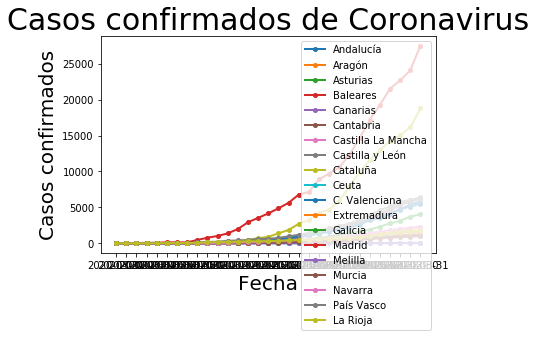

In [54]:
# Dataset de partida https://github.com/AlbertoCasasOrtiz/Coronavirus-Spain-Dataset

# Saco la última columna del dataframe habitual y sustituir símbolos para igualar fecha
from datetime import datetime
date_today_brut = data_ccaa.iloc[19,6]
date_today_evolution = date_today_brut[:8]
date_today_evolution_final = str(pd.Timestamp(date_today_evolution))
date_today_evolution_final = date_today_evolution_final[:10]

list_ccaa = ['Andalucía','Aragón','Asturias','Baleares','Canarias','Cantabria','Castilla La Mancha','Castilla y León','Cataluña','Ceuta','C. Valenciana','Extremadura','Galicia','Madrid','Melilla','Murcia','Navarra','País Vasco', 'La Rioja']

# Importo los datos y reindexo
data_ccaa_evolution_last = pd.read_json (r'https://api.chollx.es/coronavirus/ca', encoding= 'utf-8')
data_ccaa_evolution_last.set_index(["ccaa"], inplace = True, append = False, drop = True)

# Renombro la columna con la fecha
data_ccaa_evolution_last.rename(columns = {'casos_totales':date_today_evolution_final}, index={'ccaa': 'Comunidades Autónomas'}, inplace = True)
data_ccaa_evolution_last = data_ccaa_evolution_last.iloc[0:19]
data_ccaa_evolution_column = data_ccaa_evolution_last[date_today_evolution_final]
data_ccaa_evolution_column

# Cargo dataset de partida
data_process = pd.read_csv("covid19_spain_ccaa_evolution2.csv", sep = ';', encoding="utf-8") #cambiar el data evolution a 2 depsué de primera subida
data_process = data_process.set_index('Comunidades Autónomas')

# Hacer merge si es necesario con condicional
if data_process.columns[-1] == data_ccaa_evolution_last.columns[0]:
    print('La columna ya está: no hacer merge')
else:
    print('La última columna es diferente y no está: SE HACE MERGE')
    data_process = pd.merge(data_process,data_ccaa_evolution_column, left_index=True, right_index=True)
    
#Exportar a CSV
data_process.to_csv('covid19_spain_ccaa_evolution2.csv', sep = ';', encoding="utf-8", index=True, index_label='Comunidades Autónomas')
print(data_process.head())

'''Vamos a hacer un gráfico para ver los casos confirmados por fechas'''
data_process_graphic= data_process.copy().transpose()
plt.plot(data_process_graphic, label='France', marker='o', markersize=4, linewidth=2)
plt.title('Casos confirmados de Coronavirus', {'fontsize': 30})
plt.xlabel("Fecha", {'fontsize': 20})
plt.ylabel("Casos confirmados", {'fontsize': 20})
plt.legend(list_ccaa)


## Gráfico + CSV: covid19_spain_ccaa.csv datos principales

In [55]:
# Poner bien los datos
data_ccaa_general = data_ccaa.iloc[0:19]
data_ccaa_general = data_ccaa_general.loc[:, ['casos_totales', 'fallecidos','hospitalizados','curados','nuevos_respecto_ayer']]
data_ccaa_general.rename(columns = {'CCAA':'Comunidades autónomas', 'casos_totales':'Casos totales' + ' - ' + date_today, 'fallecidos':'Fallecidos'+ ' - ' + date_today, 'hospitalizados':'Hospitalizados'+ ' - ' + date_today, 'nuevos_respecto_ayer':'Nuevos casos (24h)' + ' - ' + date_today, 'curados':'Curados' + ' - ' + date_today}, inplace = True)

#Exportar CSV
data_ccaa_general.to_csv('covid19_spain_ccaa.csv', sep = ';', encoding="utf-8")
data_ccaa_general.head()

,Casos totales - 31/03,Fallecidos - 31/03,Hospitalizados - 31/03,Curados - 31/03,Nuevos casos (24h) - 31/03
ccaa,,,,,
Andalucía,5818,248,2867,160,413
Aragón,2272,138,1176,204,194
Asturias,1236,55,529,90,78
Baleares,1069,42,399,111,69
Canarias,1262,55,483,57,58


# Subir archivos a SERVIDOR desde FTP

In [56]:
import csv
from ftplib import FTP
from io import StringIO

In [57]:
# Ayuda: https://www.pythoncircle.com/post/668/uploading-a-file-to-ftp-server-using-python/

passw = pd.read_csv("pass.txt", sep = ',', encoding="utf-8")
host = "akakicreations.com"
username = passw.columns[0]
password = passw.columns[1]

ftp = FTP(host=host)

login_status = ftp.login(user=username, passwd=password)
print(login_status)

print(ftp.dir())
fp = open("covid19_data_drive_days.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_data_drive_days.csv"), fp, 1024)
fp = open("covid19_data_drive_from100.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_data_drive_from100.csv"), fp, 1024)
fp = open("covid19_spain_ccaa.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_spain_ccaa.csv"), fp, 1024)
fp = open("covid19_spain_ccaa_evolution2.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_spain_ccaa_evolution2.csv"), fp, 1024)
fp = open("covid19_data_drive_actual.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_data_drive_actual.csv"), fp, 1024)
fp.close()


230-OK. Current restricted directory is /
230 10 Kbytes used (0%) - authorized: 51200 Kb
drwxr-xr-x    2 akakicre   akakicre         4096 Mar 31 18:32 .
drwxr-xr-x    2 akakicre   akakicre         4096 Mar 31 18:32 ..
-rw-------    1 akakicre   akakicre            8 Mar 31 18:32 .ftpquota
-rw-r--r--    1 akakicre   akakicre          277 Mar 31 18:32 covid19_data_drive_actual.csv
-rw-r--r--    1 akakicre   akakicre         4379 Mar 31 18:32 covid19_data_drive_days.csv
-rw-r--r--    1 akakicre   akakicre         2524 Mar 31 18:32 covid19_data_drive_from100.csv
-rw-r--r--    1 akakicre   akakicre          687 Mar 31 18:32 covid19_spain_ccaa.csv
-rw-r--r--    1 akakicre   akakicre         2670 Mar 31 18:32 covid19_spain_ccaa_evolution2.csv
None


In [ ]:
# Pruebas
# Coger los datos de otra fuente:
data_ccaa_new = pd.read_csv(r'https://covid19tracking.narrativa.com/csv/confirmed.csv', encoding= 'utf-8')
data_ccaa_new = data_ccaa_new[data_ccaa_new['Country_EN'] == 'Spain']
data_ccaa_new = data_ccaa_new.drop(columns=['Country_EN', 'Country_ES'])
data_ccaa_new.sort_values('Region')